In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
from sklearn.linear_model import Lasso
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
import os



In [2]:
sys.path.append(os.path.join("..", "utils"))
from synthetic_data import generate_synthetic_data

# Simulate syntehtic Data

In [33]:
# simulate the datas
data = generate_synthetic_data(p = 16, r = 8, n = 1000, rep=256)

criterion (2) : 0.9254199520916189


100%|██████████| 256/256 [00:00<00:00, 383.88it/s]


In [30]:
%%capture
# do the multiple lasso regressions
mu_range = np.exp(- np.linspace(0, 15, 50))
final_grid = np.zeros((16, 50))
for i in tqdm(range(256)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(50):
        mu = mu_range[k]
        lasso_reg = Lasso(alpha=mu, max_iter=10000)
        lasso_reg.fit(X, y)
        coef = lasso_reg.coef_ 
        final_grid[:,k] += (coef != 0)*1
;

KeyboardInterrupt: 

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

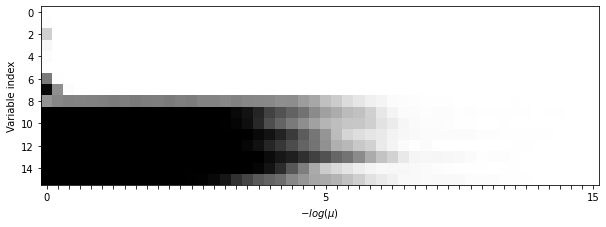

In [32]:

figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 256, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;


In [39]:
from bolasso_algorithm import bolasso

In [50]:
%%capture

nb_mu = 50 # nu
nb_rep = 10


mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid = np.zeros((16, nb_mu))
for i in tqdm(range(nb_rep)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=128, mu=mu)
        coef = res["coef"] 
        final_grid[:,k] += (coef != 0)*1
;

''

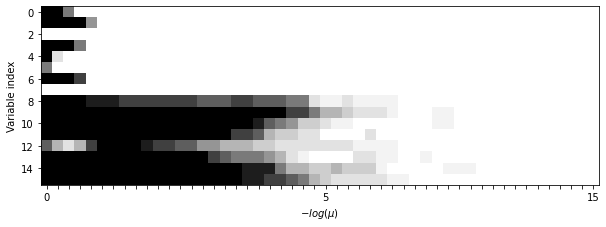

In [52]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / nb_rep, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(nb_mu))
ax.set_xlabel(np.linspace(0, 15, 10))
ax.set_xlabel("$-log(\mu)$")

d = dict(zip([0, 25, 49], [0, 5, 15]))

x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(nb_mu)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;